<CENTER><img src="../images/ATLASOD.gif" style="width:50%"></CENTER>

# <CENTER><h1>Reconstruction of invariant mass of Z boson decaying into two leptons </h1></CENTER>

## Simple pyROOT notebook example
In this notebook you can find an easy set of commands that show the basic computing techniques commonly used in high energy  physics (HEP) analysis. It also shows how to create a histogram, fills it, draws it and uses a fit function on it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. At the end you get a plot with the invariant mass of the two leptons system, which represents the mass of the Z boson.

The Analysis is implemented by using some useful tools, such as `pandas` (to storage dataframes), `numpy` (the numerical library of python), `uproot3` (to read root files), `matplotlib` (to plot our graphics) and `scipy` library (which allows us to fit our histogram using a gaussian function).

<a id='contents'></a>

# Contents: 

[To setup everytime](#setup_everytime) <br />
[Importing some useful libraries in python](#useful_libraries) <br />
[Opening a ROOT file and setting up some parameters](#parameters) <br />
[Functions declaration](#functions_declaration) <br />
[Changing a cut](#changing_a_cut) <br />
[Applying a cut](#applying_a_cut) <br />
[Some useful methods in pandas](#pandas_methods) <br />
[Plotting](#plotting) <br />

<a id='setup_everytime'></a>

## To setup everytime

First at all, we should verify that we have installed all the needed tools to perform our analysis. If we haven't, we can run the next code line:

In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

'\nimport sys\n!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer\n!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages\n'

<a id='useful_libraries'></a>

## Importing some useful libraries in python

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [2]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from scipy.optimize import curve_fit

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


[Back to contents](#contents)

<a id='parameters'></a>

# Opening a ROOT file and setting up some parameters

The root file which contains the events information is stored in the [1largeRjet1lep folder](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/). So we are going to define the **path_file** variable which contains the url and the name of the root file:

In [3]:
path_file = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/mc_361106.Zee.1largeRjet1lep.root'

Using **uproot3**, we define our tree from the root file and we will print the number of total events by defining a new variable called `numevents`: 

In [4]:
tree = uproot3.open(path_file)["mini"] # open the tree called mini
numevents = uproot3.numentries(path_file, "mini") # number of events
print("Number of events: ", numevents)

Number of events:  53653


The `fraction` variable is defined in case we don't want to run our analysis over the whole events in the root file, but if it is not the case, you can leave it as equal to 1.0

In [5]:
fraction = 1.0

[Back to contents](#contents)

<a id='functions_declaration'></a>

# Functions declaration

Next, we define a function that computes the invariant mass of the two leptons system. This function requires the $pT$, $\eta$, $\phi$ and $E$ of each lepton to return the invariant mass.

In [6]:
def calc_mll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*np.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*np.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*np.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*np.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*np.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*np.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    sumpx = px_0 + px_1 # x-component of momentum
    sumpy = py_0 + py_1 # y-component of momentum
    sumpz = pz_0 + pz_1 # z-component of momentum 
    sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] # energy of dilepton system
    return np.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

When we want to fit some data to a certain function, we can previously define it and then use it at the end of the analysis. For this reason, we define the gaussian function with the parameters that we are going to fit (the amplitude, the mean value $\mu$ and the standard deviation $\sigma$):  

In [7]:
def gauss(x, amp, mu, sigma):
    return amp*np.exp(-((x-mu)**2)/(2*sigma**2))

[Back to contents](#contents)

<a id='changing_a_cut'></a>

# Changing a cut

Now, we are ready to implement some basic cuts in our data. Here, we can find three main cuts, which are:
* **1**. `At least two leptons`: Remove all events in which the lepton number in the final state is less than 2.
* **2**. `Opposite charge cut`: Remove all events in which the two leptons in the final state have opposite charge
* **3**. `Lepton type cut`: Remove all events in which the two leptons in the final state don't belong to the same family.

In [8]:
def at_least_two_leptons_cut(lep_n):
    if(lep_n < 2): return False
    return True


def opposite_charges_cut(lep_charge):
    if(lep_charge[0] == lep_charge[1]): return False
    return True


def lep_type_cut(lep_type):
    if(lep_type[0] != lep_type[1]): return False
    return True

[Back to contents](#contents)

<a id='applying_a_cut'></a>

# Applying a cut

The next code line is going to implement the cuts over the data and save the selected events in a dataframe using `pandas`. 

In [9]:
data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample

branches = ["lep_n","lep_charge","lep_type","lep_pt",
            "lep_phi","lep_eta","lep_E"] # add more variables here if you want to use them

for data in tree.iterate(branches, 
                        outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                        entrystop=numevents*fraction): # process up to numevents*fraction
    nIn = len(data.index) # number of events in this batch
    
    # Cut applied in the number of leptons
    data = data[ np.vectorize(at_least_two_leptons_cut)(data.lep_n)]
    
    # Cut applied in the lepton's charge
    data = data[ np.vectorize(opposite_charges_cut)(data.lep_charge)]
    
    # Cut applied in the lepton's type
    data = data[ np.vectorize(lep_type_cut)(data.lep_type)]
    
    # Calculate reconstructed dilepton invariant mass using the function calc_mll defined above
    data['mll'] = np.vectorize(calc_mll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
    
    nOut = len(data.index) # number of events passing cuts in this batch
    print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
    data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample

	 nIn: 53653,	 nOut: 	37415


Once we have performed our analysis, we can visualize our selected events and their information ($pT$, $\phi$, $\eta$, $E$ and the invariant mass of the event) as follow:

In [10]:
data_all.reset_index(drop=True, inplace = True) ## Used to define a new index enumerated until nout(events passing the selection)
data_all ## Use it if you want to see all information about the events

,lep_n,lep_charge,lep_type,lep_pt,lep_phi,lep_eta,lep_E,mll
0,2,"[1, -1]","[11, 11]","[169903.48, 142998.28]","[3.0199232, -2.9465997]","[-1.8025961, -1.29893]","[529270.06, 281577.66]",93.331758
1,2,"[-1, 1]","[11, 11]","[211820.23, 78281.89]","[-3.0646539, 2.5374086]","[0.047025315, -0.12980008]","[212054.48, 78942.266]",88.992679
2,2,"[1, -1]","[11, 11]","[234039.14, 8108.9414]","[-2.36613, -0.6087628]","[0.5145523, -0.5389483]","[265711.38, 9315.408]",82.511463
3,2,"[-1, 1]","[11, 11]","[282535.56, 60798.965]","[-2.322139, -1.9640917]","[-0.15060467, -0.712555]","[285745.8, 76898.055]",88.020189
4,2,"[-1, 1]","[11, 11]","[193694.88, 135181.3]","[-1.3102051, -1.2278727]","[0.43973032, -0.09355457]","[212725.27, 135773.31]",88.329195
...,...,...,...,...,...,...,...,...
37410,2,"[1, -1]","[11, 11]","[245795.55, 222063.52]","[2.5181298, 2.6780536]","[0.12005247, -0.23323603]","[247568.95, 228130.97]",90.976534
37411,2,"[-1, 1]","[11, 11]","[264119.16, 29385.602]","[-0.56256586, -0.42886025]","[0.5077818, -0.1588098]","[298907.66, 29756.941]",60.965769
37412,2,"[-1, 1]","[11, 11]","[188751.66, 24947.594]","[0.45541525, -0.84419966]","[1.8628806, 1.3455658]","[622643.8, 51151.938]",90.463265
37413,2,"[-1, 1]","[11, 11]","[174998.83, 79250.9]","[1.6153971, 2.137508]","[0.63657373, 0.06841107]","[211669.52, 79436.42]",91.072780


[Back to contents](#contents)

<a id='pandas_methods'></a>

# Some useful methods in pandas

After applying the selection criteria to data, we could see some useful methods implemented in pandas that might help us to get a deeper analysis of our data. For example, we applied a cut in the number of the leptons in the final state that accepted all events with more than 2 leptons. Due to the fact that we are using a MC sample, we might think that our process ($Z \rightarrow ll$) must have only two leptons in the final state, but is it true? Let's use the [**value_counts()**](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method to count how many events we have per number of leptons in the final state:

In [11]:
data_all["lep_n"].value_counts()

2    37212
3      200
4        3
Name: lep_n, dtype: int64

As we can see from the result shown above, most of our data have 2 leptons in the final state as we expected, an a few percentage of the data have 3 or 4 leptons in the final state, none of them have more than 4 leptons or less than 2 leptons in the final state. The **value_count** method is useful because we didn't need to see row by row to count the number of leptons per event and we got a list of the number of events with the number of leptons in the final state anyway. 
Let's see more information of our data, such as the lower and higher value of the invariant mass in all of our data, which were computed by the function "**calc_mll**", by using the [**min()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html) and [**max()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html) methods:

In [12]:
min = data_all["mll"].min()
max = data_all["mll"].max()
print("Range: [{:.2f} GeV, {:.2f} GeV]".format(min, max))

Range: [10.03 GeV, 2012.54 GeV]


The result above tells us that we have a wide range in the **mll** column values, so we might think that our invariant mass could be very dispersed. Let's use interquartile ranges to see a little bit how the distribution of the invariant mass values is. To do this, we can see the middle interquartile range (that is the range between the $25%$ and $75%$ quartiles).

In [13]:
quar_25 = data_all["mll"].quantile(q=0.25)
quar_75 = data_all["mll"].quantile(q=0.75)

rang_int_quartil = quar_75 - quar_25
print(
    "The invariant mass for the middle 50% of events range from {:.2f} GeV to {:.2f} GeV.\nThis is an interquartile range of {:.2f} GeV."
    .format(quar_25, quar_75, rang_int_quartil)
)

The invariant mass for the middle 50% of events range from 88.88 GeV to 94.05 GeV.
This is an interquartile range of 5.18 GeV.


The middle interquartile range has told us that half of the data for the invariant mass is contained between 88.88 GeV and 94.05 GeV. So even if the range of the invariant mass is high, half of our data of the invariant mass should be contained in a thin range near to 91 GeV (that is almost the mass of the Z boson). What happens if we wanted to get these statistics values but now considering the number of leptons in the final state? Fortunately, we can use the [**groupby()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [**describe()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) methods to get some of these statistical values for the number of leptons in the final state. In this case, we are going to group our data with the "**lep_n**" column and get the statistical values for the "**mll**" column just as follow:

In [14]:
data_all.groupby("lep_n")["mll"].describe()

,count,mean,std,min,25%,50%,75%,max
lep_n,,,,,,,,
2,37212.0,131.654342,145.063251,10.028786,88.879591,91.125424,94.054349,2012.540042
3,200.0,136.524102,161.862118,21.354651,88.255994,91.245386,93.343718,1146.912383
4,3.0,89.810701,4.025477,87.326921,87.488463,87.650005,91.052591,94.455177


The **describe()** method gives us the mean, the standard deviation, the minimum value, the maximum value and the $25%$, $50%$ and $75%$ quartiles values for a certain column (in our case the invariant mass column) at the same time. We also can modify our data a little bit, such as creating new columns and using some methods over columns we already have.

Let's define some functions that we are going to use to illustrate how the [**apply()**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method works.
First we can define two functions that give the first and second value of an array into a serie of a dataframe:

In [15]:
def first_value_of_the_array(serie):
    first = serie[0]
    return first

In [16]:
def second_value_of_the_array(serie):
    second = serie[1]
    return second

Then, we can create a function that tells us what kind of lepton we have in the final state (such an electron, positron, muon or antimuon). Of course, we can know it by using the **lep_type** and **lep_charge** columns but we want to have a column with the name of the particle in order to easily compare the number of electrons, positrons, muons or antimuons we have in all the events. In another way, we should find the PDG ID for every lepton and use the lepton charge to identify leptons of the same family. 

In [17]:
def assign_type(lep_charge, lep_type):
    if(lep_charge == -1):
        if(lep_type==11):
            label = "electron"
    if(lep_charge == 1):
        if(lep_type==11):
            label = "positron"
    if(lep_charge == -1):
        if(lep_type==13):
            label = "muon"
    if(lep_charge == 1):
        if(lep_type==13):
            label = "antimuon"
    return label

Let's create four new columns that contain the type and charge for the leading and subleading leptons. To save this information in the new columns, we use the **apply()** method over the **lep_type** and **lep_charge** columns, giving the name of the funcion we are going to apply over these values for each lepton. Then, we should see these new columns in the dataframe such as follow (the first 10 events):

In [18]:
data_all["leadlep_type"] = data_all["lep_type"].apply(first_value_of_the_array)
data_all["subleadlep_type"] = data_all["lep_type"].apply(second_value_of_the_array)
data_all["leadlep_charge"] = data_all["lep_charge"].apply(first_value_of_the_array)
data_all["subleadlep_charge"] = data_all["lep_charge"].apply(second_value_of_the_array)

data_all[["lep_n", "lep_type", "lep_charge", "leadlep_type", "subleadlep_type", "leadlep_charge", "subleadlep_charge"]].head(10)

,lep_n,lep_type,lep_charge,leadlep_type,subleadlep_type,leadlep_charge,subleadlep_charge
0,2,"[11, 11]","[1, -1]",11,11,1,-1
1,2,"[11, 11]","[-1, 1]",11,11,-1,1
2,2,"[11, 11]","[1, -1]",11,11,1,-1
3,2,"[11, 11]","[-1, 1]",11,11,-1,1
4,2,"[11, 11]","[-1, 1]",11,11,-1,1
5,2,"[11, 11]","[-1, 1]",11,11,-1,1
6,2,"[11, 11]","[-1, 1]",11,11,-1,1
7,2,"[11, 11]","[1, -1]",11,11,1,-1
8,2,"[11, 11]","[-1, 1]",11,11,-1,1
9,2,"[11, 11]","[-1, 1]",11,11,-1,1


As we can see from the result above, we have separated the information of the type and charge of the leading and subleading leptons and now, we could use these four columns to determine what the leading and subleading leptons are by using the [**vectorize()**](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) function of numpy library:

In [19]:
data_all["leading_lepton"] = np.vectorize(assign_type)(data_all.leadlep_charge,data_all.leadlep_type)
data_all["subleading_lepton"] = np.vectorize(assign_type)(data_all.subleadlep_charge,data_all.subleadlep_type)

data_all[["lep_n", "lep_type", "lep_charge", "leading_lepton", "subleading_lepton"]].head(10)

,lep_n,lep_type,lep_charge,leading_lepton,subleading_lepton
0,2,"[11, 11]","[1, -1]",positron,electron
1,2,"[11, 11]","[-1, 1]",electron,positron
2,2,"[11, 11]","[1, -1]",positron,electron
3,2,"[11, 11]","[-1, 1]",electron,positron
4,2,"[11, 11]","[-1, 1]",electron,positron
5,2,"[11, 11]","[-1, 1]",electron,positron
6,2,"[11, 11]","[-1, 1]",electron,positron
7,2,"[11, 11]","[1, -1]",positron,electron
8,2,"[11, 11]","[-1, 1]",electron,positron
9,2,"[11, 11]","[-1, 1]",electron,positron


Let's count how many electrons and positrons we have as a leading lepton using the **value_counts()** method explained above:

In [20]:
data_all["leading_lepton"].value_counts()

electron    19148
positron    18267
Name: leading_lepton, dtype: int64

Because of the cuts in the type and charge leptons given by the functions **opposite_charges_cut** and **lep_type_cut** defined early, we should expect that we have the number of electrons and positrons swapped when we count for the subleading lepton column. This is because we should guarantee that we have leptons of the same family and opposite charges, and the first two leptons of each event only have electrons or positrons (there aren't muons or antimuons as leading or subleading leptons). Let's verify it:

In [21]:
data_all["subleading_lepton"].value_counts()

positron    19148
electron    18267
Name: subleading_lepton, dtype: int64

Ok! It looks good. Now, we are going to plot how many electrons and positrons are leading and subleading leptons, sorting them according to the number of leptons in the final state. We should expect to have the majority of contribution of leptons in events with only two leptons in the final state, with a lower percentage in events with three and four leptons in the final state. Let's create a new dataframe named **elec_pos** in which we are going to count the number of electrons and positrons by grouping them with the number of leptons in the final state for each event.

In [22]:
#elec_pos = data_all[data_all["lep_n"] == 2].groupby("lep_n")["lep1_charge"].value_counts()
elec_pos = data_all.groupby("lep_n")["leading_lepton"].value_counts()

elec_pos

lep_n  leading_lepton
2      electron          19050
       positron          18162
3      positron            102
       electron             98
4      positron              3
Name: leading_lepton, dtype: int64

<AxesSubplot:title={'center':'Number of leading leptons sorted by electrons and positrons'}, xlabel='Number of electrons and positrons per number of leptons in the final state', ylabel='Number of electrons and positrons'>

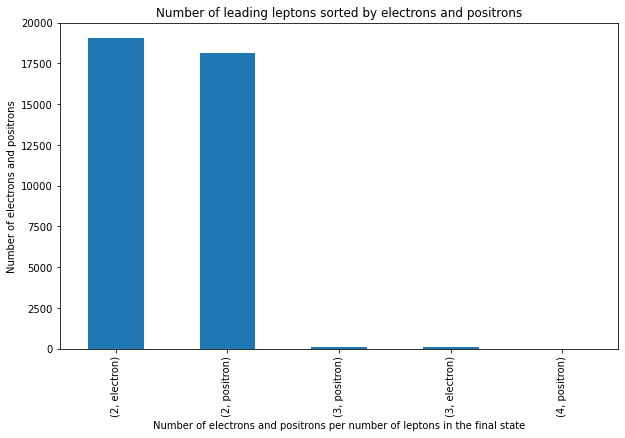

In [23]:
elec_pos.plot.bar(title="Number of leading leptons sorted by electrons and positrons", 
                  xlabel = "Number of electrons and positrons per number of leptons in the final state", 
                  ylabel = "Number of electrons and positrons", figsize=(10,6))

[Back to contents](#contents)

<a id='plotting'></a>

# Plotting

Now, we only need to plot our final graphs. For this reason, we create two functions which plots our data using points and the other one using histograms. In these plots we can see our fit using a gaussian function we previously defined.

Run the next two code lines if you want to see the plot with points:

In [24]:
def plot_data():   

    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data_all['mll'], 
                            bins=bin_edges ) # histogram the data   
         
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                      fmt='ko', # 'k' means black and 'o' means circles
                      label='Data' ) 

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    
    # data fit
    
    popt,pcov = curve_fit(gauss, bin_centres, data_x, p0=(10000, 90, 5))
    
    y = gauss(bin_centres, popt[0], popt[1], popt[2])
    
    plt.plot(bin_centres, y, color='r', linestyle='dashed', label='Gaussian Fit Function')
    
    mu = np.format_float_positional(popt[1], unique=False, precision=2)
    sigma = np.format_float_positional(popt[2], unique=False, precision=2)

    # Add text 'Invariant mass of Z boson given by the gaussian fit function'
    plt.text(0.6, # x
             0.56, # y
             'Mass of Z boson given by', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.5, # y
             'the gaussian fit function', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.44, # y
             r'$m_{Z} = $ '+mu + '$\pm$' + sigma, # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes    
    
    # Add text 'ATLAS Open Data' on plot
    plt.text(0.1, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.1, # x
             0.86, # y
             'for education - not public', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    #lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.1, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.1, # x
             0.74, # y
             r'$Z \rightarrow l^{+}l^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    # 'upper left', 'upper right', 'lower left', 'lower right'
    main_axes.legend(frameon=False, # no box around the legend
                     loc='upper right' ) # legend location 
    
    # x-axis label
    plt.xlabel(r'di-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]')
    
    # y-axis label
    plt.ylabel('Events')

    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.yticks(np.arange(0, 10000, step=1000))
    
    plt.title('Mass of the Z boson')
    plt.savefig('plots/Z-invariant-mass/Zmass_pandas_p.pdf')
    #plt.savefig('plots/Z-invariant-mass/Zmass_pandas_p.png')
    
    return

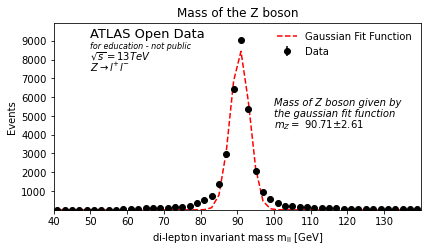

In [25]:
plot_data()

Run the next two code lines if you want to see the plot as histograms:

In [26]:
def plot_data_2(data):
    
    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    main_axes = plt.gca() # get current axes
    
    # plot data histogram
    data_hist = main_axes.hist(data['mll'], bins=bin_edges, color='#0011ff', label='Data') 
    
    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=False, # draw ticks on the top axis
                          right=False ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right')
    
    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.yticks(np.arange(0, 10000, step=1000))
    
    plt.title('Mass of the Z boson')
    
    # data fit
    
    data_x,_ = np.histogram(data_all['mll'], bins=bin_edges ) # histogram the data   
        
    popt,pcov = curve_fit(gauss, bin_centres, data_x, p0=(10000, 90, 5))
    
    y = gauss(bin_centres, popt[0], popt[1], popt[2])
    
    plt.plot(bin_centres, y, color='r', linestyle='dashed', label='Gaussian Fit Function')
    
    mu = np.format_float_positional(popt[1], unique=False, precision=2)
    sigma = np.format_float_positional(popt[2], unique=False, precision=2)

    # Add text 'Invariant mass of Z boson given by the gaussian fit function'
    plt.text(0.6, # x
             0.56, # y
             'Mass of Z boson given by', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.5, # y
             'the gaussian fit function', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.44, # y
             r'$m_{Z} = $ '+mu + '$\pm$' + sigma, # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes   
    
    # draw the legend
    main_axes.legend( frameon=False,
                    loc='upper right' ) # no box around the legend 
    
    # Add text 'ATLAS Open Data' on plot
    main_axes.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    main_axes.text(0.05, # x
             0.88, # y
             'for education - not public', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 )
    
    main_axes.text(0.05, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    main_axes.text(0.05, # x
             0.74, # y
             r'$Z \rightarrow l^{+}l^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    plt.savefig('plots/Z-invariant-mass/Zmass_pandas_h.pdf')
    #plt.savefig('plots/Z-invariant-mass/Zmass_pandas_h.png')
    
    return

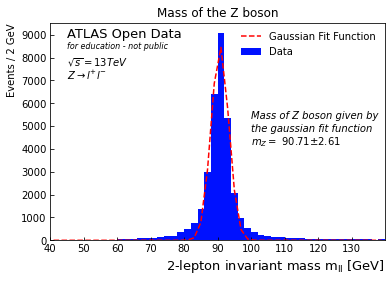

In [27]:
plot_data_2(data_all)

[Back to contents](#contents)